In [1]:
pip install pydicom

     |████████████████████████████████| 35.3 MB 88 kB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install SimpleITK

     |████████████████████████████████| 42.5 MB 12.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


max of up graph 85.33306820248585
max of right graph 86.24014043118997


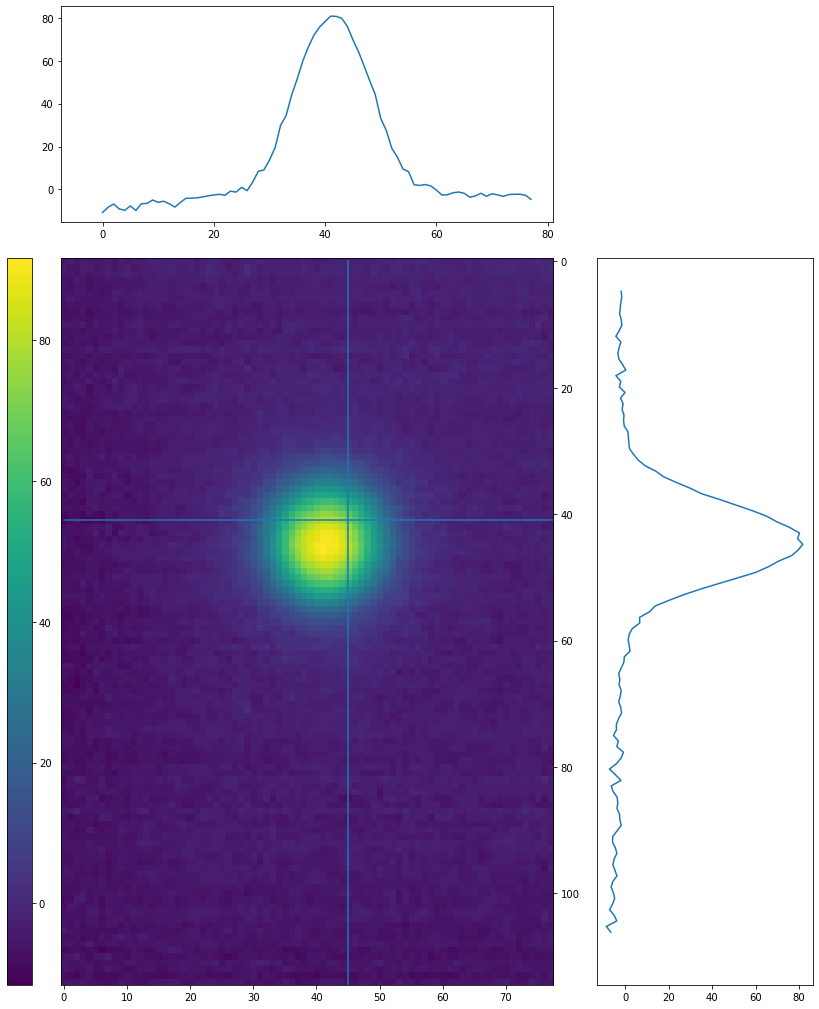

In [161]:
# DRAW MATPLOTLIB IN NOTEBOOK #

# %matplotlib inline
# %matplotlib notebook



# LIBRARIES #

import numpy as np

import pydicom as dcm

import matplotlib.pyplot as plt

from matplotlib import gridspec

from matplotlib.lines import Line2D

from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy import ndimage

import SimpleITK



# INPUT PARAMETERS #
#m_filename = 'G:/Commun/PHYSICIENS/cyber M6/OF/EBT3/colli5_200dpi.tif'
m_filename = 'colli5_72dpi.tif'

m_coefA = 1774.1   #x3
m_coefB = -3907.8  #x2
m_coefC = 3276.7   #x
m_coefD = -935.12



# READS THE IMAGE AND CONVERTS IT TO DOSE #

def readAndConvertImg(filename, coefs):
    # reads the image using simpleITK:
    img = SimpleITK.ReadImage(filename)
    sizex = img.GetWidth()
    sizey = img.GetHeight()
    array = SimpleITK.GetArrayFromImage(img)

    # replaces every 65535 value in array with 65534 to avoid division by zero:
    array[array==65535]=65534

    # converts in optical density
    dor = -np.log10(array[:,:,0]/65535.0)
    dob = -np.log10(array[:,:,2]/65535.0)

    # red channel over blue channel:
    rsb = dor/dob
    rsb[rsb>1.3] = 1.3

    # converting in dose:
    dose = coefs[0]*rsb**3 + coefs[1]*rsb**2 + coefs[2]*rsb + coefs[3]

    return dose, sizex, sizey



# PLOTS THE DOSE IMAGE #

coefs = [m_coefA, m_coefB, m_coefC, m_coefD]

doseimg, sizex, sizey = readAndConvertImg(m_filename, coefs)

plt.rcParams['figure.figsize'] = (30,18)

fig, ax1 = plt.subplots()
im1 = ax1.imshow(doseimg)#, cmap="Greys", vmin = 0, vmax = 100)
ax1.yaxis.set_label_position('right')
ax1.yaxis.tick_right()
#ax1.set_title('Dose')
#ax1.axes.get_xaxis().set_visible(False)
#ax1.axes.get_yaxis().set_visible(False)
ax1.axes.autoscale(False)

com = ndimage.measurements.center_of_mass(doseimg[10:sizex-10,10:sizey-10])
comx = int(com[0])+10
comy = int(com[1])+10

com = ndimage.measurements.center_of_mass(doseimg[comx-10:comx+10, comy-10:comy+10])
comx += int(com[0])-10
comy += int(com[1])-10

#comx = 45
#comy = 41

# Points 
linex = [0,sizex]
liney = [comy,comy]
line1 = plt.Line2D(linex, liney)
ax1.add_line(line1)
linex = [comx,comx]
liney = [0,sizey]
line2 = plt.Line2D(linex, liney)
ax1.add_line(line2)


try:
    divider1 = make_axes_locatable(ax1)
    
    cax1 = divider1.append_axes('left', size='5%', pad=0.4)
    plt.colorbar(im1, cax=cax1)
    
    ax2 = divider1.append_axes('top', 3, pad=0.5, sharex=axScatter)
    ax2.plot(doseimg[comy,:])
    
    ax3 = divider1.append_axes('right', 3, pad=0.6, sharey=axScatter)
    ax3.plot(doseimg[:,comx][::-1],range(sizey))
    ax3.yaxis.set_visible(False)
    
    print("max of up graph", ax2.get_ylim()[1])
    print("max of right graph", ax3.get_xlim()[1])
    
except:
    print('Error displaying images side bars')


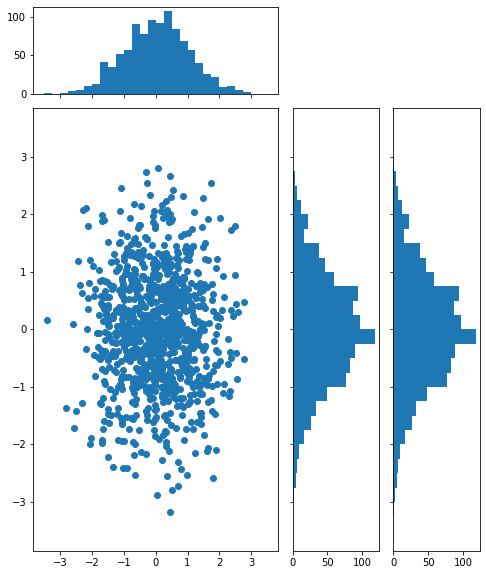

In [159]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# the random data
x = np.random.randn(1000)
y = np.random.randn(1000)


fig, axScatter = plt.subplots(figsize=(8, 10))

# the scatter plot:
axScatter.scatter(x, y)

# create new axes on the right and on the top of the current axes
# The first argument of the new_vertical(new_horizontal) method is
# the height (width) of the axes to be created in inches.
divider = make_axes_locatable(axScatter)
axHistx = divider.append_axes('top', 1.2, pad=0.2, sharex=axScatter)
axHisty = divider.append_axes('right', 1.2, pad=0.2, sharey=axScatter)
axHisty2 = divider.append_axes('right', 1.2, pad=0.2, sharey=axScatter)

# make some labels invisible
plt.setp(axHistx.get_xticklabels() + axHisty.get_yticklabels() + axHisty2.get_yticklabels(),
         visible=False)

# now determine nice limits by hand:
binwidth = 0.25
xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
lim = (int(xymax/binwidth) + 1)*binwidth

bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.hist(x, bins=bins)
axHisty.hist(y, bins=bins, orientation='horizontal')
axHisty2.hist(y, bins=bins, orientation='horizontal')

# the xaxis of axHistx and yaxis of axHisty are shared with axScatter,
# thus there is no need to manually adjust the xlim and ylim of these
# axis.

#axHistx.axis["bottom"].major_ticklabels.set_visible(False)
for tl in axHistx.get_xticklabels():
    tl.set_visible(False)
axHistx.set_yticks([0, 50, 100])

#axHisty.axis["left"].major_ticklabels.set_visible(False)
for tl in axHisty.get_yticklabels():
    tl.set_visible(False)
axHisty.set_xticks([0, 50, 100])

for tl in axHisty2.get_yticklabels():
    tl.set_visible(False)
axHisty2.set_xticks([0, 50, 100])

plt.draw()
plt.show()

In [ ]:
ax2 = fig.add_subplot(gs[0])
im2 = ax2.plot(doseimg[comy,:])
print("max of up graph",ax2.get_ylim()[1])

ax3 = fig.add_subplot(gs[3])
im3 = ax3.plot(doseimg[:,comx])
print("max of right graph",ax3.get_ylim()[1])